# Explicit Discretization of Diffusion

We'll start with our diffusion equation:

$$\phi_t = k \phi_{xx}$$

by replacing the time derivative with a forwardd-difference (first-order accurate)
and the second derivative in space with a centered difference (second-order accurate):

$$\frac{\phi_i^{n+1} - \phi_i^n}{\Delta t} = k \frac{\phi_{i+1}^n - 2 \phi_i^n + \phi_{i-1}^n}{\Delta x^2}$$

## Stability

This is reminiscent of the FTCS method we saw with advection, so we need to ask&mdash;is this discretization stable?

As this equation is linear, we can do [von Neumann stability analysis](https://en.wikipedia.org/wiki/Von_Neumann_stability_analysis).  We look at a
single Fourier mode:

$$\phi_i^n = A^n e^{ji\theta}$$

where we are using $j = \sqrt{-1}$ for the imaginary unit.  Stability requires that:

$$\left | \frac{A^{n+1}}{A^n} \right | \le 1$$

When we work this out, we find that this discretization is stable as long as:

$$\Delta t \le \frac{1}{2} \frac{\Delta x^2}{k}$$

Notice that the spatial dependence here is more severe than advection&mdash;we scale
as $\Delta x^2$.

We'll use a cell-centered finite-difference / finite-volume grid.

Here's the grid class.  It implements Neumann boundary conditions by simply setting the ghost cell values to the value just inside the domain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
class Grid:
    """ a simple class to hold cell-centered finite-difference  /
    finite-volume data """

    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = np.zeros((nx+2*ng), dtype=np.float64)

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the ghostcells with zero gradient (Neumann)
            boundary conditions """
        self.phi[0:self.ilo] = self.phi[self.ilo]
        self.phi[self.ihi+1:] = self.phi[self.ihi]

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))

Here's the integration routine.  We require a function to be passed in with the initial conditions
of the form:

```
init_cond(grid, k)
```

where `grid` is the `Grid` object and `k` is the thermal diffusivity.

We'll take a timestep based on the stability criteron:

$$\Delta t = \frac{C}{2} \frac{\Delta x^2}{k}$$

where $C < 1$ is a _safety factor_ that ensures that we remain stable.

In [17]:
def diffuse_explicit(nx, k, C, tmax, init_cond):
    """ evolve the system with diffusion coeff k and CFL number C """

    ng = 1

    # create the grid
    g = Grid(nx, ng)

    # time info
    dt = C * 0.5 * g.dx**2 / k
    t = 0.0

    # initialize the data
    g.phi[:] = init_cond(g, k)

    # evolution loop
    phinew = g.scratch_array()

    while t < tmax:

        # make sure we end right at tmax
        if t + dt > tmax:
            dt = tmax - t

        # fill the boundary conditions
        g.fill_BCs()

        alpha = k * dt / g.dx**2

        # loop over zones
        for i in range(g.ilo, g.ihi+1):

            # explicit diffusion
            phinew[i] = g.phi[i] + alpha * (g.phi[i+1] - 2.0*g.phi[i] + g.phi[i-1])

        # store the updated solution
        g.phi[:] = phinew[:]
        t += dt

    return g

Here are our initial conditions&mdash;the Gaussian profile.

In [18]:
def gaussian_ic(g, k, t=0.0, t0=1.e-4, phi1=1.0, phi2=2.0):
    xc = 0.5*(g.xmin + g.xmax)
    return (phi2 - phi1) * (np.sqrt(t0/(t + t0)) *
                            np.exp(-0.25 * (g.x - xc)**2 / (k * (t + t0)))) + phi1

We'll pick a maximum time in terms of the diffusion timescale,

$$\tau_\mathrm{diffuse} \sim \frac{\lambda^2}{k}$$

where $\lambda$ is the characteristic size we are diffusing over.  We'll
pick it as $\lambda \sim \Delta x$ since we start out very strongly peaked.

In [28]:
nx = 64
C = 0.5

k = 1

t_char = (1.0/nx)**2 / k

We'll run for a few different multiples of the characteristic time and
plot the evolution

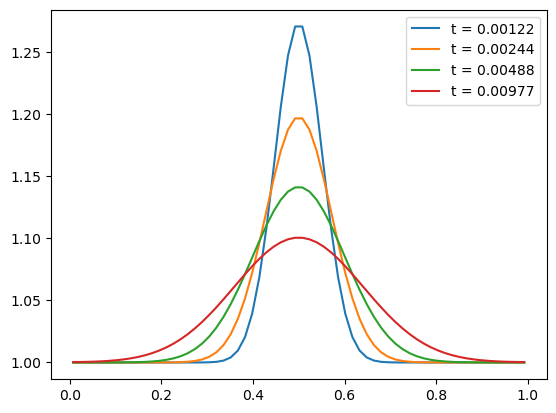

In [35]:
fig, ax = plt.subplots()

for n in [1, 2, 4, 8]:
    g = diffuse_explicit(nx, k, C, n * tmax, gaussian_ic)
    ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"t = {n * tmax:7.5f}")

ax.legend()

In [24]:
tmax

1.0